In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime as dt
import plotly.io as pio
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import pickle
import warnings
warnings.filterwarnings('ignore')
pio.templates.default = 'plotly'

In [2]:
df=pd.read_csv('/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv')

In [3]:
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isnull().mean()*100

dt                                            0.000000
LandAverageTemperature                        0.375940
LandAverageTemperatureUncertainty             0.375940
LandMaxTemperature                           37.593985
LandMaxTemperatureUncertainty                37.593985
LandMinTemperature                           37.593985
LandMinTemperatureUncertainty                37.593985
LandAndOceanAverageTemperature               37.593985
LandAndOceanAverageTemperatureUncertainty    37.593985
dtype: float64

My decision to use only the columns `LandAverageTemperature`, `LandAverageTemperatureUncertainty`, and `dt` is reasonable given the high percentage of missing values in the other columns (around 37.59%). Since these two columns (`LandAverageTemperature` and `LandAverageTemperatureUncertainty`) have minimal missing data (only 0.38%), they are reliable for analysis and forecasting.


In [5]:
df.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')

In [6]:
df=df[['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']]

In [7]:
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574
1,1750-02-01,3.083,3.702
2,1750-03-01,5.626,3.076
3,1750-04-01,8.490,2.451
4,1750-05-01,11.573,2.072


In [8]:
df.dtypes

dt                                    object
LandAverageTemperature               float64
LandAverageTemperatureUncertainty    float64
dtype: object

In [9]:
df[df.isnull().any(axis=1)]

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
10,1750-11-01,NaN,NaN
16,1751-05-01,NaN,NaN
18,1751-07-01,NaN,NaN
21,1751-10-01,NaN,NaN
22,1751-11-01,NaN,NaN
23,1751-12-01,NaN,NaN
25,1752-02-01,NaN,NaN
28,1752-05-01,NaN,NaN
29,1752-06-01,NaN,NaN
30,1752-07-01,NaN,NaN


In [10]:
df[df['LandAverageTemperature']<0]

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
49,1754-02-01,-1.249,7.492
61,1755-02-01,-0.108,5.857
84,1757-01-01,-0.276,4.022
96,1758-01-01,-1.503,7.349
120,1760-01-01,-0.811,4.567
143,1761-12-01,-0.837,4.468
192,1766-01-01,-0.793,4.766
204,1767-01-01,-0.643,5.656
216,1768-01-01,-2.080,3.027
239,1769-12-01,-0.978,2.291


### Handling Missing Data and negative temperature:

Filter the DataFrame to include only rows with dates from the year 1839 onwards.


In [11]:
df['dt'] = pd.to_datetime(df['dt'])

In [12]:
df = df[df['dt'].dt.year > 1838]

In [13]:
df.dtypes

dt                                   datetime64[ns]
LandAverageTemperature                      float64
LandAverageTemperatureUncertainty           float64
dtype: object

In [14]:
fig = px.line(df, x='dt', y='LandAverageTemperature', title='Land Average Temperature Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')
fig.show()

In [15]:
fig = px.line(df, x='dt', y='LandAverageTemperatureUncertainty', title='Land Average Uncertainty Temperature Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')
fig.show()

In [16]:
fig = px.scatter(df, x='dt', y=['LandAverageTemperature', 'LandAverageTemperatureUncertainty'],
              labels={'value': 'Temperature (°C)', 'variable': 'Legend'},
              title='Land Average Temperature and Uncertainty Over Time',trendline='ols', trendline_color_override='white')
fig.update_traces(mode='markers+lines')
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')
fig.show()

In [17]:
fig = px.line(df, x='dt', y='LandAverageTemperature', color=df['dt'].dt.year, 
              title='Land Average Temperature Over Time')

# Update layout for axis titles
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')

# Show the plot
fig.show()

In [18]:
fig = px.line(df, x='dt', y='LandAverageTemperature', color=df['dt'].dt.month_name(), 
              title='Land Average Temperature Over Time')

# Update layout for axis titles
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')

# Show the plot
fig.show()

In [19]:
fig = px.line(df, x='dt', y='LandAverageTemperatureUncertainty', color=df['dt'].dt.year, 
              title='Land Average Uncertainty Temperature Over Time')

# Update layout for axis titles
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')

# Show the plot
fig.show()

In [20]:
fig = px.line(df, x='dt', y='LandAverageTemperatureUncertainty', color=df['dt'].dt.month_name(), 
              title='Land Average Uncertainty Temperature Over Time')

# Update layout for axis titles
fig.update_layout(xaxis_title='Date', yaxis_title='Temperature (°C)')

# Show the plot
fig.show()

In many historical climate datasets, older measurements (like those from the 18th or 19th century) tend to have higher Uncertainty because of less advanced measurement techniques, fewer data points, or incomplete records. As the technology for recording temperature improved, more recent data generally comes with lower uncertainty.


In [21]:
df.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty'], dtype='object')

<Axes: >

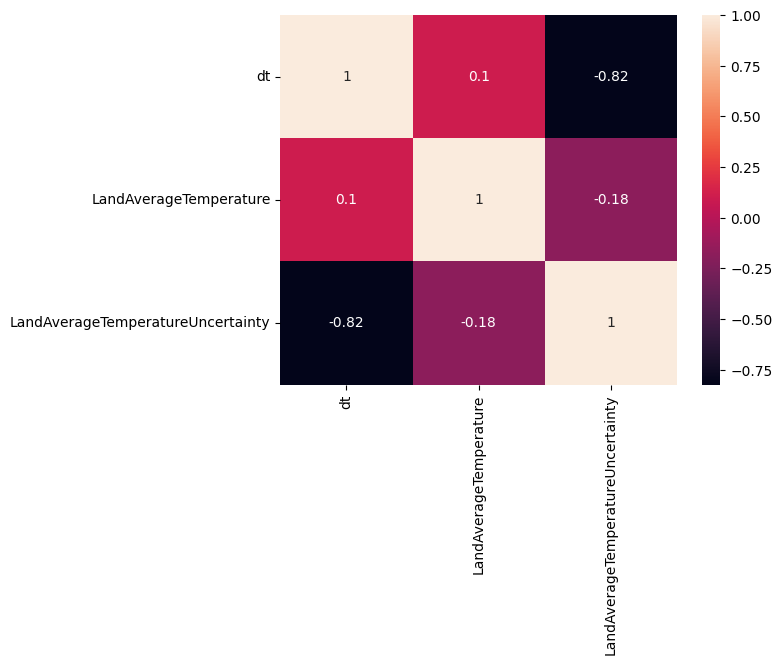

In [22]:
sns.heatmap(df.corr(),annot=True)

`-0.18`: A weak negative linear relationship. This suggests that as one variable increases, the other tends to decrease slightly, but the relationship is weak.


In [23]:
df.describe()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
count,2124,2124.000000,2124.000000
mean,1927-06-17 04:14:54.915254016,8.532746,0.317744
min,1839-01-01 00:00:00,0.404000,0.034000
25%,1883-03-24 06:00:00,4.394750,0.104000
50%,1927-06-16 00:00:00,8.810000,0.241000
75%,1971-09-08 12:00:00,12.828250,0.392500
max,2015-12-01 00:00:00,15.482000,1.761000
std,NaN,4.272775,0.281473


In [24]:
midpoint = len(df) // 2
first_half = df.iloc[:midpoint]
second_half = df.iloc[midpoint:]
first_half_mean = first_half['LandAverageTemperature'].mean()
first_half_variance = first_half['LandAverageTemperature'].var()
second_half_mean = second_half['LandAverageTemperature'].mean()
second_half_variance = second_half['LandAverageTemperature'].var()
print(f"First Half - Mean: {first_half_mean}, Variance: {first_half_variance}")
print(f"Second Half - Mean: {second_half_mean}, Variance: {second_half_variance}")

First Half - Mean: 8.161643126177026, Variance: 18.833191157158172
Second Half - Mean: 8.903848399246705, Variance: 17.421532132509217


In [25]:
midpoint = len(df) // 2
first_half = df.iloc[:midpoint]
second_half = df.iloc[midpoint:]
first_half_mean = first_half['LandAverageTemperatureUncertainty'].mean()
first_half_variance = first_half['LandAverageTemperatureUncertainty'].var()
second_half_mean = second_half['LandAverageTemperatureUncertainty'].mean()
second_half_variance = second_half['LandAverageTemperatureUncertainty'].var()
print(f"First Half - Mean: {first_half_mean}, Variance: {first_half_variance}")
print(f"Second Half - Mean: {second_half_mean}, Variance: {second_half_variance}")

First Half - Mean: 0.5014293785310735, Variance: 0.08559276739245035
Second Half - Mean: 0.1340593220338983, Variance: 0.005392449823479608


In [26]:
def ADFTest(series):
    adf_result = adfuller(df[series])

    # Print ADF test results
    print(f"Column Name: {series}")
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print(f'Critical Values: {adf_result[4]}')

    # Check stationarity based on p-value
    if adf_result[1] <= 0.05:
        print("The series is stationary (reject the null hypothesis).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis).")

In [27]:
ADFTest('LandAverageTemperature')

Column Name: LandAverageTemperature
ADF Statistic: -1.5771847491384083
p-value: 0.4950433962230062
Critical Values: {'1%': -3.43346776730731, '5%': -2.8629172977475434, '10%': -2.567503208390023}
The series is non-stationary (fail to reject the null hypothesis).


In [28]:
ADFTest('LandAverageTemperatureUncertainty')

Column Name: LandAverageTemperatureUncertainty
ADF Statistic: -3.5529395382671365
p-value: 0.006727145055436505
Critical Values: {'1%': -3.4334722331103045, '5%': -2.86291926951847, '10%': -2.5675042582416148}
The series is stationary (reject the null hypothesis).


### Inference of Our Plot, Simple Statistics (Mean and Variance), and ADF Test:

1. **LandAverageTemperature** is non-stationary.
2. **LandAverageTemperatureUncertainty** is stationary.

### Plan of Action:

To convert the non-stationary series to stationary, we will use a log transformation. This approach is straightforward and makes it easy to reverse using an exponential function. We will apply the log transformation on LandAverageTemperature


In [29]:
df['LogLandAverageTemperature'] = np.log(df['LandAverageTemperature'])

In [30]:
df.isnull().sum()

dt                                   0
LandAverageTemperature               0
LandAverageTemperatureUncertainty    0
LogLandAverageTemperature            0
dtype: int64

In [31]:
ADFTest('LogLandAverageTemperature')

Column Name: LogLandAverageTemperature
ADF Statistic: -3.066366902729874
p-value: 0.029144398664804793
Critical Values: {'1%': -3.433470743088496, '5%': -2.862918611634496, '10%': -2.56750390795719}
The series is stationary (reject the null hypothesis).


### Plan of Action for Model Building

1. **Model with `LandAverageTemperature` Only**
2. **Model with `LandAverageTemperature` and `LandAverageTemperatureUncertainty`**
3. **Compare Models and Select the Best**


In [32]:
df.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LogLandAverageTemperature'],
      dtype='object')

In [33]:
df.rename(columns={'LogLandAverageTemperature': 'y','dt':'ds'}, inplace=True)

In [34]:
df.head()

,ds,LandAverageTemperature,LandAverageTemperatureUncertainty,y
1068,1839-01-01,2.156,1.681,0.768255
1069,1839-02-01,3.482,1.546,1.247607
1070,1839-03-01,2.673,1.493,0.983201
1071,1839-04-01,7.892,0.920,2.065850
1072,1839-05-01,10.289,0.680,2.331075


In [35]:
uniModel = Prophet()
uniModel.fit(df)

11:24:37 - cmdstanpy - INFO - Chain [1] start processing
11:24:37 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future_data = uniModel.make_future_dataframe(periods=365, freq = 'M')

In [37]:
forecast_data = uniModel.predict(future_data)

In [38]:
forecast_data_orig = forecast_data 
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

In [39]:
# Create the figure
fig = go.Figure()

# Add trace for actual values
fig.add_trace(go.Scatter(x=df['ds'], 
                         y=df['LandAverageTemperature'], 
                         mode='lines', 
                         name='Actual Values', 
                         line=dict(color='blue')))

# Add trace for predicted values
fig.add_trace(go.Scatter(x=forecast_data_orig['ds'], 
                         y=forecast_data_orig['yhat'], 
                         mode='lines', 
                         name='Predicted Values', 
                         line=dict(color='red')))

# Add trace for the upper bound of predictions
fig.add_trace(go.Scatter(x=forecast_data_orig['ds'], 
                         y=forecast_data_orig['yhat_upper'], 
                         mode='lines', 
                         name='Upper Bound', 
                         line=dict(color='gray', dash='dash')))

# Add trace for the lower bound of predictions
fig.add_trace(go.Scatter(x=forecast_data_orig['ds'], 
                         y=forecast_data_orig['yhat_lower'], 
                         mode='lines', 
                         name='Lower Bound', 
                         line=dict(color='gray', dash='dash')))

# Update layout for better visuals
fig.update_layout(title='Actual vs Predicted Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature (°C)',
                  legend_title='Legend',)

# Show the plot
fig.show()

In [40]:
multiModel = Prophet()

In [41]:
multiModel.add_regressor('LandAverageTemperatureUncertainty')

In [42]:
multiModel.fit(df)

11:24:39 - cmdstanpy - INFO - Chain [1] start processing
11:24:39 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
future_data = multiModel.make_future_dataframe(periods=365, freq = 'M')

In [44]:
future_data = future_data.merge(df[['ds', 'LandAverageTemperatureUncertainty']], how='left', left_on='ds', right_on='ds')
future_data['LandAverageTemperatureUncertainty'].fillna(method='ffill', inplace=True)

In [45]:
forecast_data = multiModel.predict(future_data)

In [46]:
forecast_data_orig = forecast_data 
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

In [47]:
# Create the figure
fig = go.Figure()

# Add trace for actual values
fig.add_trace(go.Scatter(x=df['ds'], 
                         y=df['LandAverageTemperature'], 
                         mode='lines', 
                         name='Actual Values', 
                         line=dict(color='blue')))

# Add trace for predicted values
fig.add_trace(go.Scatter(x=forecast_data_orig['ds'], 
                         y=forecast_data_orig['yhat'], 
                         mode='lines', 
                         name='Predicted Values', 
                         line=dict(color='red')))

# Add trace for the upper bound of predictions
fig.add_trace(go.Scatter(x=forecast_data_orig['ds'], 
                         y=forecast_data_orig['yhat_upper'], 
                         mode='lines', 
                         name='Upper Bound', 
                         line=dict(color='gray', dash='dash')))

# Add trace for the lower bound of predictions
fig.add_trace(go.Scatter(x=forecast_data_orig['ds'], 
                         y=forecast_data_orig['yhat_lower'], 
                         mode='lines', 
                         name='Lower Bound', 
                         line=dict(color='gray', dash='dash')))

# Update layout for better visuals
fig.update_layout(title='Actual vs Predicted Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature (°C)',
                  legend_title='Legend',)

# Show the plot
fig.show()

### Decision on Forecasting Model

**Observation:**
Both univariate and multivariate models exhibit similar performance levels and accuracy.

**Decision:**
Opt to use the univariate model for further forecasting.

**Rationale:**

1. **Simplicity:** Univariate models are typically simpler to implement and interpret compared to multivariate models.
2. **Efficiency:** Univariate models often require less computational resources and are faster to run, making them suitable for scenarios with limited data or computational power.
3. **Consistency:** Since both models perform similarly, choosing the simpler univariate model avoids the additional complexity of incorporating multiple variables.


In [48]:
with open('prophet_uniModel.pkl', 'wb') as file:
    pickle.dump(uniModel, file)